In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from datetime import timedelta
import datetime as dt
from sklearn.linear_model import BayesianRidge, LinearRegression, Ridge

%matplotlib inline

# Exploratory Data Analysis

Here we are going to experiment with our data in order to get the most insights possible before building a Machine Learning Model

In [45]:
#import data for the analysis

base_train = pd.read_csv('train.csv')
base_test = pd.read_csv('test.csv')
base_train.head()

train = base_train
test = base_test

## Creating Datetime Variables

In [46]:
## Adjusting datetime data

def clean_datetime(df):
    df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
    df.loc[:, 'pickup_week'] = df.pickup_datetime.apply(lambda x: x.isocalendar()[1])
    df.loc[:, 'pickup_weekday'] = df.pickup_datetime.apply(lambda x: x.weekday())
    df.loc[:, 'pickup_hour'] = df.pickup_datetime.apply(lambda x: x.hour)
    return df

train = clean_datetime(train)
test = clean_datetime(test)

## Transforming and Normalizing the target variable

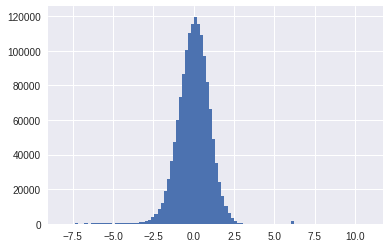

In [47]:
train['log_duration'] = np.log(train['trip_duration'].values)
#maybe also normalize it
#Saving the mean and standard devition to revert the transformation
logmean = train['log_duration'].mean()
logstd = train['log_duration'].std()

train['log_duration'] = (train.log_duration - logmean)/logstd

plt.hist(train['log_duration'].values, bins = 100)
plt.show()

## Analyzing Position Variables

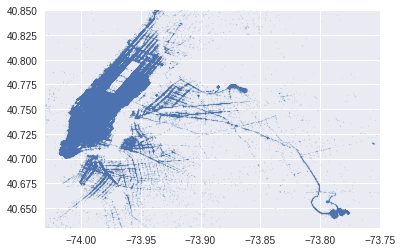

In [48]:
xlim = (-74.03, -73.75)
ylim = (40.63, 40.85)

plt.scatter(train['pickup_longitude'].values, train['pickup_latitude'].values,  s = 1, alpha = 0.1)
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

Here we are going to create new positional values, these are the haversine distance and the manhattan distance, the manhatan distance is just the sum of the individual distances.

In [49]:
def haversine(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    radius = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * radius * np.arcsin(np.sqrt(d))
    return h

def L1_distance(lat1, lng1, lat2, lng2):
    a = haversine(lat1, lng1, lat1, lng2)
    b = haversine(lat1, lng1, lat2, lng1)
    return a + b

def create_distances(df):
    df.loc[:, 'haversine'] = haversine(df['pickup_latitude'].values, df['pickup_longitude'].values, df['dropoff_latitude'].values, df['dropoff_longitude'].values)
    df.loc[:, 'l1_dist'] = haversine(df['pickup_latitude'].values, df['pickup_longitude'].values, df['dropoff_latitude'].values, df['dropoff_longitude'].values)
    return df

In [50]:
train = create_distances(train)
test = create_distances(test)

## Getting rid of unwanted variables

In [51]:
def clean_df(df):
    df.drop('store_and_fwd_flag', axis = 1)
    df.drop('vendor_id', axis = 1)
    df.drop('id', axis = 1)
    df.drop('pickup_datetime', axis = 1)
    return df

In [52]:
train = clean_df(train)
test = clean_df(test)


#Creating label vector
ydata = train['log_duration']
train = train.drop('log_duration', axis = 1)
train = train.drop('trip_duration', axis = 1)
train = train.drop('dropoff_datetime', axis = 1)

(-10, 25)

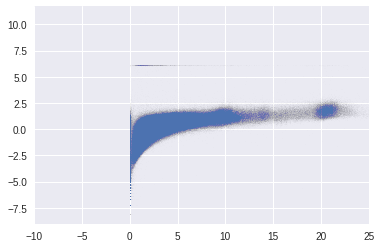

In [57]:
plt.scatter(train['l1_dist'], ydata, s = 1, alpha = 0.002)
plt.xlim(-10,25)


In [60]:
## get the dummy variables

pd.concat(train['l1_dist', pd.get_dummies(train.pickup_hour)])

TypeError: 'DataFrame' objects are mutable, thus they cannot be hashed

## Logtransform L1 - distance and haversine

Here we try to correct the skewness of the L1-distance with a log transorm



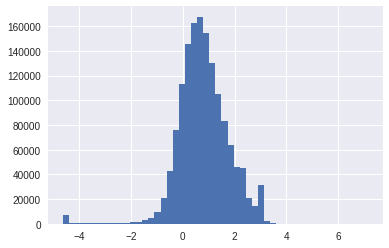

In [10]:
l1train = newtrain['L1_distance'].apply(lambda x: np.log(x + 0.01))
havertrain = newtrain['haversine'].apply(lambda x: np.log(x + 0.01))

havertrain.hist(bins = 50)

Maybe we would like to normalize it in order to have 0 mean and unit standard deviation

In [11]:
newtrain['L1_distance'] = (l1train - l1train.mean())/l1train.std()
newtrain['haversine'] = (havertrain - havertrain.mean())/havertrain.std()

##We do it also for the test data set
l1test = newtest['L1_distance'].apply(lambda x: np.log(x + 0.01))
havertest = newtest['haversine'].apply(lambda x: np.log(x + 0.01))
newtest['L1_distance'] = (l1test -l1test.mean())/l1test.std()
newtest['haversine'] = (havertest - havertest.mean())/havertest.std()

Lets plot this histogram together with the log trip duration to see if we are going to have some correlation

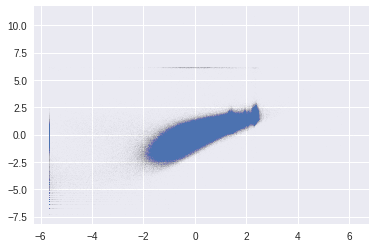

In [12]:
plt.scatter(newtrain['L1_distance'], ydata, s = 1, alpha = 0.002)

In [13]:
##normalizing the latitudes and longitudes

pickuplat = newtrain['pickup_latitude'].apply(lambda x: np.log(x))
pickuplat = (pickuplat - pickuplat.mean())/pickuplat.std()
newtrain['pickup_latitude'] = pickuplat
pickuplong = newtrain['pickup_longitude'].apply(lambda x: np.log(-x))
pickuplong = (pickuplong - pickuplong.mean())/pickuplong.std()
newtrain['pickup_longitude'] = pickuplong

pickuplat2 = newtest['pickup_latitude'].apply(lambda x: np.log(x))
pickuplat2 = (pickuplat2 - pickuplat2.mean())/pickuplat2.std()
newtest['pickup_latitude'] = pickuplat2
pickuplong2 = newtest['pickup_longitude'].apply(lambda x: np.log(-x))
pickuplong2 = (pickuplong2 - pickuplong2.mean())/pickuplong2.std()
newtest['pickup_longitude'] = pickuplong2


that looks like correlation, now lets do one hot encoding on the weekday and hour because thats more of a categorical value and not numerical in nature. 

In [14]:
weektrain = pd.get_dummies(newtrain['weekday'])
weektrain.columns = ['m','t','w', 'th', 'f', 's', 'su']
hourstrain = pd.get_dummies(newtrain['hour'])

weektest = pd.get_dummies(newtest['weekday'])
weektest.columns = ['m','t','w', 'th', 'f', 's', 'su']
hourstest = pd.get_dummies(newtest['hour'])


These are functions for regression that we are going to need in the future, we are also including a delog function.

In [58]:
def delog(y, mean, std):
    res = y*std + mean
    res = np.exp(res) + 0.01
    return res

def rmsle(predicted, real):
    """Root mean square logarithmic error."""
    sum = 0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return np.sqrt(sum/len(predicted))
        

In [16]:
Xkmeanstrain = pd.concat([train['pickup_longitude'] , train['pickup_latitude']], axis = 1)
Xkmeanstest = pd.concat([test['pickup_longitude'] , test['pickup_latitude']], axis = 1)

In [17]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 20, random_state = 0).fit(Xkmeanstrain.as_matrix())

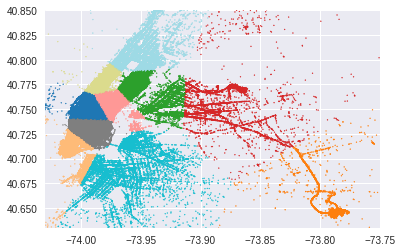

In [19]:
LABEL_COLOR_MAP = {0 : 'r',
                   1 : 'k',
                   2 : 'g',
                   3 : 'b',
                   4 : 'm',
                   5 : 'r',
                   6 : 'g',
                   7 : 'b',
                   8 : 'm',
                   9 : 'c',
                   10 : 'r',
                   11 : 'k',
                   12 : 'g',
                   13 : 'b',
                   14 : 'm',
                   15 : 'r',
                   16 : 'g',
                   17 : 'b',
                   18 : 'm',
                   19 : 'c',
                   }

label_color = [LABEL_COLOR_MAP[l] for l in kmeans.labels_]

plt.scatter(train['pickup_longitude'], train['pickup_latitude'], s = 1, c = kmeans.labels_, cmap = 'tab20')
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

In [20]:
clusterstrain = pd.get_dummies(pd.DataFrame(kmeans.labels_)[0])
clusterstest = pd.get_dummies(pd.DataFrame(kmeans.predict(Xkmeanstest))[0])

In [21]:
Xdata = pd.concat([newtrain['haversine'], train['trip_duration'], newtrain['passenger_count'], newtrain['L1_distance'], newtrain['pickup_latitude'] , newtrain['pickup_longitude'], weektrain, hourstrain, clusterstrain], axis = 1)
ydata = ydata

#,newtrain['pickup_latitude'],newtrain['pickup_longitude']
Xsub = pd.concat([newtest['haversine'],newtest['passenger_count'], newtest['L1_distance'], newtest['pickup_latitude'] , newtest['pickup_longitude'],  weektest, hourstest, clusterstest], axis = 1)

In [22]:
## CROSS VALIDATION
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata.as_matrix(), ydata.as_matrix(), test_size = 0.4, random_state = 0)
##removing the time for training

Xtraintime = Xtrain[:,1]
Xtesttime = Xtest[:,1]
Xtrain = np.delete(Xtrain, 1, axis = 1)
Xtest = np.delete(Xtest, 1, axis =  1)

In [23]:
## MATRICES FOR REGRESSION

from sklearn.ensemble import RandomForestRegressor

etrain = []
etest = []

for cons in [20]:
    reg = RandomForestRegressor(max_depth=cons, random_state=0)
    reg.fit(Xtrain, ytrain)
    
    ypredlogtrain = reg.predict(Xtrain)
    ypredlogtrain = np.array(ypredlogtrain).reshape((len(ypredlogtrain, )))
    ypredtrain = delog(ypredlogtrain, logmean, logstd)
    
    errortrain = rmsle(ypredtrain.reshape((len(ypredtrain,))), Xtraintime)
    etrain.append(errortrain)
    
    ypredlogtest = reg.predict(Xtest)
    ypredlogtest = np.array(ypredlogtest).reshape((len(ypredlogtest, )))
    ypredtest = delog(ypredlogtest, logmean, logstd)
    
    errortest = rmsle(ypredtest.reshape((len(ypredtest,))), Xtesttime)
    etest.append(errortest)

What about the logarithmic error of the aactual train function

In [29]:
from sklearn import linear_model

#reg = linear_model.Ridge(alpha = 0.1)
#reg.fit(Xtrain, ytrain)
    
ypredlog = reg.predict(Xsub)
ypredlog = np.array(ypredlog).reshape((len(ypredlog, )))
ypred = delog(ypredlog, logmean, logstd)

In [30]:
submission = pd.concat([test['id'],pd.DataFrame(ypred)], axis = 1)
submission.columns = ['id', 'trip_duration']
submission.to_csv('submission.csv', index = False)

In [ ]:
test['id'].as_matrix().shape